<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/objectdetection/sam%2Bblip%2Bclip%2Boneformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [ ]:
# transformers install
!pip install git+https://github.com/huggingface/transformers.git
# SAM install
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'        
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

load model

In [1]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import cv2

import pycocotools.mask as mask_util

In [2]:
device = "cuda"

In [3]:
# load SAM model with mask generator
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator = SamAutomaticMaskGenerator(sam, output_mode="coco_rle")

concept study

In [4]:
img_path = "/content/room003.jpeg"
image = Image.open(img_path)
cv2_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

In [5]:
# SAM mask autogeneration
masks = mask_generator.generate(cv2_image)

In [6]:
print(len(masks))

84


In [15]:
# ['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']
print(masks[0]["crop_box"])

[0, 0, 1000, 667]


In [16]:
import json
result_dict = {}
for label_id in range(len(masks)):
  mask_item = masks[label_id]
  area = mask_item["area"]
  bbox = mask_item["bbox"]

  item_dict = {
      "area": area,
      "bbox": bbox,
      "stability_score": mask_item["stability_score"],
      "crop_box": mask_item["crop_box"]
  }
  result_dict[label_id] = item_dict

save_json_path = img_path.replace(img_path.split(".")[-1], ".json")
json.dump(result_dict, open(save_json_path, "w"))


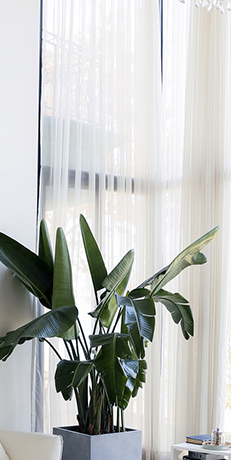

In [7]:
mask_id = 0
bboxes = masks[mask_id]["bbox"]
xmin, ymin, width, height = masks[mask_id]["bbox"]  # xmin, ymin, width, height
crop_image = cv2_image[ymin:ymin+height, xmin:xmin+width, :]
crop_image_pil = Image.fromarray(crop_image)
display(crop_image_pil)

In [1]:
from transformers import AutoProcessor, BlipForConditionalGeneration
from transformers import CLIPProcessor, CLIPModel
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import cv2
import json

In [2]:
device = "cuda"

In [3]:
img_path = "/content/room003.jpeg"
result_json_path = img_path.replace(img_path.split(".")[-1], ".json")
image = Image.open(img_path)
cv2_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask_dict = json.load(open(result_json_path, "r"))

In [4]:
# Before start, please restart google colab
# load oneformer model
oneformer_model_name = "shi-labs/oneformer_ade20k_swin_large"
oneformer_ade20k_processor = OneFormerProcessor.from_pretrained(
            oneformer_model_name,
)
oneformer_ade20k_model = OneFormerForUniversalSegmentation.from_pretrained(
            oneformer_model_name,
).to(device)

# load blip model
blip_model_name = "Salesforce/blip-image-captioning-large"  # "base", "large"
blip_processor = AutoProcessor.from_pretrained(blip_model_name)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_name)

# load clip model
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

/usr/local/lib/python3.9/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


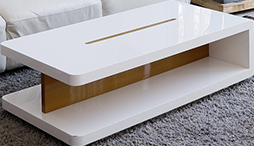

In [5]:
mask_id = 3
bboxes = mask_dict[str(mask_id)]["bbox"]
xmin, ymin, width, height = mask_dict[str(mask_id)]["bbox"]  # xmin, ymin, width, height
crop_image = cv2_image[ymin:ymin+height, xmin:xmin+width, :]
crop_image_pil = Image.fromarray(crop_image)
display(crop_image_pil)

In [6]:
# oneformer inference
inputs = oneformer_ade20k_processor(images=crop_image_pil, task_inputs=["semantic"], return_tensors="pt").to(device)
outputs = oneformer_ade20k_model(**inputs)
predicted_semantic_map = oneformer_ade20k_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[crop_image_pil.size[::-1]])[0]

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
import pycocotools.mask as mask_util
import numpy as np

In [9]:
# labels setup
coco_names_dict = {0: u'__background__',
1: u'person',
2: u'bicycle',
3: u'car',
4: u'motorcycle',
5: u'airplane',
6: u'bus',
7: u'train',
8: u'truck',
9: u'boat',
10: u'traffic light',
11: u'fire hydrant',
12: u'stop sign',
13: u'parking meter',
14: u'bench',
15: u'bird',
16: u'cat',
17: u'dog',
18: u'horse',
19: u'sheep',
20: u'cow',
21: u'elephant',
22: u'bear',
23: u'zebra',
24: u'giraffe',
25: u'backpack',
26: u'umbrella',
27: u'handbag',
28: u'tie',
29: u'suitcase',
30: u'frisbee',
31: u'skis',
32: u'snowboard',
33: u'sports ball',
34: u'kite',
35: u'baseball bat',
36: u'baseball glove',
37: u'skateboard',
38: u'surfboard',
39: u'tennis racket',
40: u'bottle',
41: u'wine glass',
42: u'cup',
43: u'fork',
44: u'knife',
45: u'spoon',
46: u'bowl',
47: u'banana',
48: u'apple',
49: u'sandwich',
50: u'orange',
51: u'broccoli',
52: u'carrot',
53: u'hot dog',
54: u'pizza',
55: u'donut',
56: u'cake',
57: u'chair',
58: u'couch',
59: u'potted plant',
60: u'bed',
61: u'dining table',
62: u'toilet',
63: u'tv',
64: u'laptop',
65: u'mouse',
66: u'remote',
67: u'keyboard',
68: u'cell phone',
69: u'microwave',
70: u'oven',
71: u'toaster',
72: u'sink',
73: u'refrigerator',
74: u'book',
75: u'clock',
76: u'vase',
77: u'scissors',
78: u'teddy bear',
79: u'hair drier',
80: u'toothbrush'}


ade20k_names_dict = {
"1": "wall",
"2": "building, edifice",
"3": "sky",
"4": "floor, flooring",
"5": "tree",
"6": "ceiling",
"7": "road, route",
"8": "bed",
"9": "windowpane, window",
"10": "grass",
"11": "cabinet",
"12": "sidewalk, pavement",
"13": "person, individual, someone, somebody, mortal, soul",
"14": "earth, ground",
"15": "door, double door",
"16": "table",
"17": "mountain, mount",
"18": "plant, flora, plant life",
"19": "curtain, drape, drapery, mantle, pall",
"20": "chair",
"21": "car, auto, automobile, machine, motorcar",
"22": "water",
"23": "painting, picture",
"24": "sofa, couch, lounge",
"25": "shelf",
"26": "house",
"27": "sea",
"28": "mirror",
"29": "rug, carpet, carpeting",
"30": "field",
"31": "armchair",
"32": "seat",
"33": "fence, fencing",
"34": "desk",
"35": "rock, stone",
"36": "wardrobe, closet, press",
"37": "lamp",
"38": "bathtub, bathing tub, bath, tub",
"39": "railing, rail",
"40": "cushion",
"41": "base, pedestal, stand",
"42": "box",
"43": "column, pillar",
"44": "signboard, sign",
"45": "chest of drawers, chest, bureau, dresser",
"46": "counter",
"47": "sand",
"48": "sink",
"49": "skyscraper",
"50": "fireplace, hearth, open fireplace",
"51": "refrigerator, icebox",
"52": "grandstand, covered stand",
"53": "path",
"54": "stairs, steps",
"55": "runway",
"56": "case, display case, showcase, vitrine",
"57": "pool table, billiard table, snooker table",
"58": "pillow",
"59": "screen door, screen",
"60": "stairway, staircase",
"61": "river",
"62": "bridge, span",
"63": "bookcase",
"64": "blind, screen",
"65": "coffee table, cocktail table",
"66": "toilet, can, commode, crapper, pot, potty, stool, throne",
"67": "flower",
"68": "book",
"69": "hill",
"70": "bench",
"71": "countertop",
"72": "stove, kitchen stove, range, kitchen range, cooking stove",
"73": "palm, palm tree",
"74": "kitchen island",
"75": "computer, computing machine, computing device, data processor, electronic computer, information processing system",
"76": "swivel chair",
"76": "swivel chair",
"77": "boat",
"78": "bar",
"79": "arcade machine",
"80": "hovel, hut, hutch, shack, shanty",
"81": "bus, autobus, coach, charabanc, double-decker, jitney, motorbus, motorcoach, omnibus, passenger vehicle",
"82": "towel",
"83": "light, light source",
"84": "truck, motortruck",
"85": "tower",
"86": "chandelier, pendant, pendent",
"87": "awning, sunshade, sunblind",
"88": "streetlight, street lamp",
"89": "booth, cubicle, stall, kiosk",
"90": "television, television receiver, television set, tv, tv set, idiot box, boob tube, telly, goggle box",
"91": "airplane, aeroplane, plane",
"92": "dirt track",
"93": "apparel, wearing apparel, dress, clothes",
"94": "pole",
"95": "land, ground, soil",
"96": "bannister, banister, balustrade, balusters, handrail",
"97": "escalator, moving staircase, moving stairway",
"98": "ottoman, pouf, pouffe, puff, hassock",
"99": "bottle",
"100": "buffet, counter, sideboard",
"101": "poster, posting, placard, notice, bill, card",
"102": "stage",
"103": "van",
"104": "ship",
"105": "fountain",
"106": "conveyer belt, conveyor belt, conveyer, conveyor, transporter",
"107": "canopy",
"108": "washer, automatic washer, washing machine",
"109": "plaything, toy",
"110": "swimming pool, swimming bath, natatorium",
"111": "stool",
"112": "barrel, cask",
"113": "basket, handbasket",
"114": "waterfall, falls",
"115": "tent, collapsible shelter",
"116": "bag",
"117": "minibike, motorbike",
"118": "cradle",
"119": "oven",
"120": "ball",
"121": "food, solid food",
"122": "step, stair",
"123": "tank, storage tank",
"124": "trade name, brand name, brand, marque",
"125": "microwave, microwave oven",
"126": "pot, flowerpot",
"127": "animal, animate being, beast, brute, creature, fauna",
"128": "bicycle, bike, wheel, cycle",
"129": "lake",
"130": "dishwasher, dish washer, dishwashing machine",
"131": "screen, silver screen, projection screen",
"132": "blanket, cover",
"133": "sculpture",
"134": "hood, exhaust hood",
"135": "sconce",
"136": "vase",
"137": "traffic light, traffic signal, stoplight",
"138": "tray",
"139": "ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin",
"140": "fan",
"141": "pier, wharf, wharfage, dock",
"142": "crt screen",
"143": "plate",
"144": "monitor, monitoring device",
"145": "bulletin board, notice board",
"146": "shower",
"147": "radiator",
"148": "glass, drinking glass",
"149": "clock",
"150": "flag"
}

In [ ]:
candidate_ade20k_words = []
for a in ade20k_names_dict.values():
  alist = a.split(",")
  candidate_ade20k_words.extend(alist)
candidate_coco_words = list(coco_names_dict.values())
candidate_words = candidate_ade20k_words + candidate_coco_words
candidate_words

In [11]:
def extract_good_bbox(predicted_semantic_map, label_id, threshold_resol=10):
  pred_semantic_map = predicted_semantic_map.cpu().numpy()
  m = np.where(pred_semantic_map==label_id, 1, 0)
  mh, mw = m.shape[:2]
  mask = np.ascontiguousarray(m)  # some versions of cv2 does not support incontiguous arr
  res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
  hierarchy = res[-1]
  has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
  res = res[-2]
  res = [x.flatten() for x in res]
  # These coordinates from OpenCV are integers in range [0, W-1 or H-1].
  # We add 0.5 to turn them into real-value coordinate space. A better solution
  # would be to first +0.5 and then dilate the returned polygon by 0.5.
  polygons = [x + 0.5 for x in res if len(x) >= 6]
  candidate_bboxes = []
  for pol_id in range(len(polygons)):
    p = mask_util.frPyObjects([polygons[pol_id]], mh, mw)
    p = mask_util.merge(p)
    bbox = mask_util.toBbox(p)
    if bbox[2] < threshold_resol or bbox[3]< threshold_resol:
      continue
    
    bbox[2] += bbox[0]
    bbox[3] += bbox[1]
    candidate_bboxes.append([pol_id, bbox])

  return candidate_bboxes
  


In [12]:
print(np.unique(predicted_semantic_map.cpu().numpy()))

[ 0  3  7 10 15 23 28 39 64]


In [39]:
label_id = 64
threshold_resol = 10
cand_bboxes = extract_good_bbox(predicted_semantic_map, label_id, threshold_resol)
if len(cand_bboxes) > 0:
  print(cand_bboxes)

[[0, array([  2.,   1., 253., 146.])]]


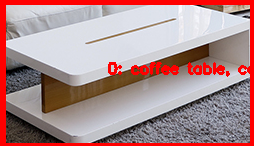

In [40]:
# display image
import cv2
temp_image = crop_image.copy()

for pol_id, bbox in cand_bboxes:
  left_point = (int(bbox[0]), int(bbox[1]))
  right_point = (int(bbox[2]), int(bbox[3]))
  text_offset = 20
  middle_point = (int(left_point[0] * 0.5 + right_point[0] * 0.5) - text_offset, int(left_point[1] * 0.5 + right_point[1] * 0.5 ))
  cv2.rectangle(temp_image, left_point, right_point, (255, 0, 0), 5)
  cv2.putText(temp_image,
              text=f"{pol_id}: {ade20k_names_dict[str(label_id + 1)]}",
              org=middle_point,
              fontFace=cv2.FONT_HERSHEY_SIMPLEX,
              fontScale=0.5,
              color=(255, 0, 0),
              thickness=2,
              lineType=cv2.LINE_4)
display(Image.fromarray(temp_image))

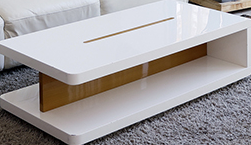

In [42]:
pol_id = 0
_, bbox = cand_bboxes[pol_id]
left_point = (int(bbox[0]), int(bbox[1]))
right_point = (int(bbox[2]), int(bbox[3]))
small_patch = crop_image[left_point[1]:right_point[1], left_point[0]:right_point[0], :]
small_patch_pil = Image.fromarray(small_patch)
display(small_patch_pil)

In [43]:
# blip caption
blip_inputs = blip_processor(images=small_patch_pil, return_tensors="pt")
pixel_values = blip_inputs.pixel_values

generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_caption

'there is a white coffee table with a gold edge on a carpet'

In [44]:
word_list = [a for a in ade20k_names_dict[str(label_id + 1)].split(",")]
for gene in generated_caption.split(" "):
  if gene in candidate_words:
    word_list.append(gene)

prefix = "a photo of"
word_list = [prefix + " " + w for w in word_list]
word_list

['a photo of coffee table', 'a photo of  cocktail table', 'a photo of table']

In [45]:
clip_inputs = clip_processor(text=word_list, images=small_patch_pil, return_tensors="pt", padding=True)

outputs = clip_model(**clip_inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
max_id = probs.argmax()
print(word_list[max_id])

a photo of coffee table
